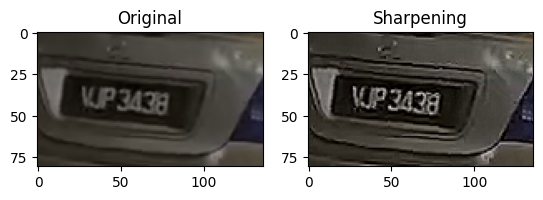

In [5]:
#Import the necessary libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image = cv2.imread('image2.png')

#Plot the original image
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image)

# Create the sharpening kernel
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

# Sharpen the image
sharpened_image = cv2.filter2D(image, -1, kernel)

#Save the image
cv2.imwrite('sharpened_image.jpg', sharpened_image)

#Plot the sharpened image
plt.subplot(1, 2, 2)
plt.title("Sharpening")
plt.imshow(sharpened_image)
plt.show()

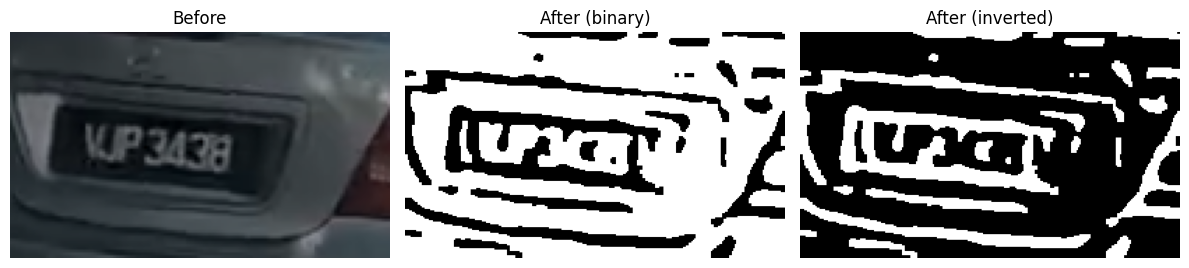

Saved to: C:\Users\hengz\Desktop\Plate\enhanced_out


In [8]:
# enhance_plate.py  (works in a notebook too)
import cv2, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def enhance_plate_for_ocr(bgr, upscale=2, gamma=1.6, block=31, C=7):
    g = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.bilateralFilter(g, 7, 50, 50)  # denoise, keep edges
    if upscale > 1:
        g = cv2.resize(g, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_CUBIC)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    g = clahe.apply(g)
    if gamma:
        lut = np.array([((i/255.0)**(1.0/gamma))*255 for i in range(256)], dtype=np.uint8)
        g = cv2.LUT(g, lut)
    th = cv2.adaptiveThreshold(g, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, block, C)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN,  k, iterations=1)
    return g, th, cv2.bitwise_not(th)

# ==== set your input image path here ====
in_path = "image2.png"   # <- replace with YOUR file path

bgr = cv2.imread(in_path)
assert bgr is not None, f"Cannot read: {in_path}"

gray, bin_img, bin_inv = enhance_plate_for_ocr(
    bgr,
    upscale=2,     # set 1 for big crops; keep 2 for tiny plates
    gamma=1.6,     # lower (1.3) for bright white plates; higher (1.8–2.0) for dark/night
    block=31,      # odd, ~21–41; smaller for tiny characters
    C=7            # tweak 5–12 depending on glare/noise
)

# save & show
out_dir = Path("enhanced_out"); out_dir.mkdir(exist_ok=True)
cv2.imwrite(str(out_dir/"before.png"), bgr)
cv2.imwrite(str(out_dir/"enh_gray.png"), gray)
cv2.imwrite(str(out_dir/"enh_binary.png"), bin_img)
cv2.imwrite(str(out_dir/"enh_inverted.png"), bin_inv)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.title("Before"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(bin_img, cmap='gray'); plt.title("After (binary)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(bin_inv, cmap='gray'); plt.title("After (inverted)"); plt.axis('off')
plt.tight_layout(); plt.show()

print("Saved to:", out_dir.resolve())